In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

In [41]:
def loopyBP(X, mu, sigma, pie, lambda0, messages, maxsteps):

    N, D = X.shape
    K = mu.shape[1]
    Lambda = lambda0.copy()
    fs = []
    eps = 1
    step = 0
    constant = 1e-15
    messages_vectorise = messages.copy()

    """
    bs is (NxK)
    Ws is (NxKxK)
    messages is (N, K, K)
    """
    bs = np.log(pie/(1-pie)) + X @ mu/sigma**2 - np.diag(mu.T @ mu)/(2*sigma**2)
    assert bs.shape == (N,K)

    Ws = -(mu.T @ mu)/(sigma**2)

    while abs(eps) > 1e-10 and  step < maxsteps:
        
        for i in range(K):

            for j in range(i+1,K):
                
                    term_1 = bs[:,i] + np.sum(messages_vectorise[:,:,i], axis=1) - messages_vectorise[:,j,i]
                    term_2 = term_1 + Ws[i,j]
                    messages_vectorise[:,i,j] = np.log((1+np.exp(term_2))/(1+np.exp(term_1)))
                    
                    ### Messages j -> i
                    term_1 = bs[:,j] + np.sum(messages_vectorise[:,:,j], axis=1) - messages_vectorise[:,i,j]
                    term_2 = term_1 + Ws[i,j]
                    messages_vectorise[:,j,i] = np.log((1+np.exp(term_2))/(1 + np.exp(term_1)))
                    
        Lambda = sigmoid(bs + np.sum(messages_vectorise, axis = 1))
        assert Lambda.shape == (N, K)

        f_ = compute_free_energy(X, mu, sigma, pie, Lambda, constant)

        if(step > 0):
            eps = f_ - fs[step - 1]
        fs.append(f_)
        step += 1
    
    return Lambda, fs[-1], fs, messages_vectorise

In [42]:
def compute_free_energy(X, mu, sigma, pie, Lambda, constant):
    Lambda[np.isclose(Lambda, 0)] = constant
    Lambda[np.isclose(Lambda, 1)] = 1 - constant
    term_1 = np.sum(np.multiply(Lambda, np.log(pie/Lambda)))
    term_2 = np.sum(np.multiply((1-Lambda), np.log((1-pie)/(1-Lambda))))
    term_3 = -N*D*np.log(sigma)
    weights = (X - Lambda @ mu.T)
    term_4 = -np.trace((2*sigma**2)**-1*(weights @ weights.T))
    term_5 = -np.sum((2*sigma**2)**-1*(Lambda - Lambda**2) @ np.diag(mu.T @ mu))
    term_6 = -N*(D/2)*np.log(2*np.pi)
    f_ = np.sum(term_1 + term_2 + term_3 + term_4 + term_5 + term_6)
    
    return f_

In [43]:
def m_step(X, ES, ESS):
    """
    mu, sigma, pie = MStep(X,ES,ESS)

    Inputs:
    -----------------
           X: shape (N, D) data matrix
          ES: shape (N, K) E_q[s]
         ESS: shape (K, K) sum over data points of E_q[ss'] (N, K, K)
                           if E_q[ss'] is provided, the sum over N is done for you.

    Outputs:
    --------
          mu: shape (D, K) matrix of means in p(y|{s_i},mu,sigma)
       sigma: shape (,)    standard deviation in same
         pie: shape (1, K) vector of parameters specifying generative distribution for s
    """
    N, D = X.shape
    if ES.shape[0] != N:
        raise TypeError('ES must have the same number of rows as X')
    K = ES.shape[1]
    if ESS.shape == (N, K, K):
        ESS = np.sum(ESS, axis=0)
    if ESS.shape != (K, K):
        raise TypeError('ESS must be square and have the same number of columns as ES')

    mu = np.dot(np.dot(np.linalg.inv(ESS), ES.T), X).T
    sigma = np.sqrt((np.trace(np.dot(X.T, X)) + np.trace(np.dot(np.dot(mu.T, mu), ESS))
                     - 2 * np.trace(np.dot(np.dot(ES.T, X), mu))) / (N * D))
    pie = np.mean(ES, axis=0, keepdims=True)
    
    return mu, sigma, pie

In [44]:
def compute_ESS(Lambda):
    """
    Computes E_q[ss'] (N, K, K), using Lambda matrix.
    """
    
    N, K = Lambda.shape
    ESS = np.zeros(shape=(N,K,K))
    
    for n in range(N):
        
        lambda_n = Lambda[n,:]
        
        for k_1 in range(K):
            
            for k_2 in range(K):
                
                ESS[n,k_1,k_2] = lambda_n[k_1]*lambda_n[k_2]
        
        diag = lambda_n - lambda_n**2
                
        ESS[n,:,:] += np.diag(diag)
    
    return ESS

In [63]:
def learn_bin_factors(X, K, iterations, maxsteps):
    
    N, D = X.shape
    Lambda, mu, pie, sigma, messages = init_params(N,D,K)
    free_energies = []
    
    for cIter in range(iterations):
        
        messages = 0.25 + np.random.rand(N,K,K)*0.5
        for i in range(K):
            messages[:,i,i] = 0.0
            
        Lambda, f, f_l, m_ = loopyBP(X, mu, sigma, pie, Lambda, messages, maxsteps)
        free_energies.append(f)
        print(f)
        ESS = compute_ESS(Lambda)
    
        mu, sigma, pie = m_step(X, Lambda, ESS)
        
    return mu, sigma, pie, Lambda, free_energies

In [64]:
def init_params(N, D, K):
    Lambda = 0.25 + np.random.rand(N,K)/2.0
    mu = 0.25 + np.random.rand(D,K)/2.0
    pie = 0.25 + np.random.rand(1,K)/2.0
    sigma = 1
    messages = 0.25 + np.random.rand(N,K,K)*0.5
    for i in range(K):
        messages[:,i,i] = 0.0
    
    return Lambda, mu, pie, sigma, messages

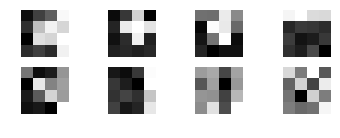

In [74]:
N=400  # number of data points - you can increase this if you want to
       # learn better features (but it will take longer).
D=16   # dimensionality of the data
# Define the basic shapes of the features

np.random.seed(0)

m1 = [0, 0, 1, 0,
      0, 1, 1, 1,
      0, 0, 1, 0,
      0, 0, 0, 0]

m2 = [0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0,
      0, 1, 0, 0]

m3 = [1, 1, 1, 1,
      0, 0, 0, 0,
      0, 0, 0, 0,
      0, 0, 0, 0]

m4 = [1, 0, 0, 0,
      0, 1, 0, 0,
      0, 0, 1, 0,
      0, 0, 0, 1] 

m5 = [0, 0, 0, 0,
      0, 0, 0, 0,
      1, 1, 0, 0,
      1, 1, 0, 0] 

m6 = [1, 1, 1, 1,
      1, 0, 0, 1,
      1, 0, 0, 1,
      1, 1, 1, 1] 

m7 = [0, 0, 0, 0,
      0, 1, 1, 0,
      0, 1, 1, 0,
      0, 0, 0, 0]

m8 = [0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1,
      0, 0, 0, 1]

nfeat = 8 # number of features
rr = 0.5 + np.random.rand(nfeat, 1) * 0.5 # weight of each feature between 0.5 and 1
mut = np.array([rr[0] * m1, rr[1] * m2, rr[2] * m3, rr[3] * m4, rr[4] * m5,
                rr[5] * m6, rr[6] * m7, rr[7] * m8])
s = np.random.rand(N, nfeat) < 0.3 # each feature occurs with prob 0.3 independently 

# Generate Data - The Data is stored in Y
Y = np.dot(s, mut) + np.random.randn(N, D) * 0.1 # some Gaussian noise is added 

nrows = 13
for k in range(8):
    plt.subplot(4, 4, k + 1)
    plt.imshow(np.reshape(Y[k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')

plt.show()

In [75]:
K = 8
iterations = 60
maxsteps = 100

mu, sig, pie, lambda_, free_energies = learn_bin_factors(Y, K, iterations, maxsteps)

-11337.06889753012
-5295.719075750824
-4813.2718656623765
-4543.844975509169
-4339.974724202575
-4066.25554064406
-3828.6763218126434
-3690.425781717651
-3587.6441659406823
-3452.169776565326
-3217.5570622036175
-3094.0241012206197
-3034.4096165345964
-2980.8261777413436
-2774.1761938898217
-2749.8864455434095
-2727.0740027359598
-2632.2605751688993
-2318.2004853273083
-2205.6734125646444
-2090.941566970578
-2100.5826253573123
-2199.7807583155754
-2064.7124907240664
-2086.7478596695237
-2116.5812500572497
-2225.0817906824495
-2146.3841586845274
-2114.579992272576
-2126.9598847902143
-2175.3726806268005
-2117.822359636195
-1990.601425873891
-2052.4979541652897
-2041.7898845818563
-1982.2986562424508
-2158.6494334604567
-2010.8660946382693
-2045.0225449433492
-2056.818034472874
-2114.7934134605844
-2124.097152854015
-2085.0850935123544
-2070.9309084194474
-2201.178254619543
-2118.786787676726
-2044.2656312279719
-2165.908402310809
-2101.0107949290373
-2144.8855590013754
-2001.48732211232

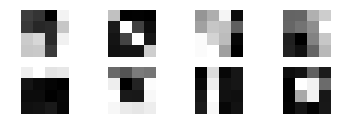

In [76]:
for k in range(K):
    plt.subplot(4, 4, k + 1)
    plt.imshow(np.reshape(mu[:,k], (4, 4)), cmap=plt.gray(), interpolation='none')
    plt.axis('off')
plt.show()

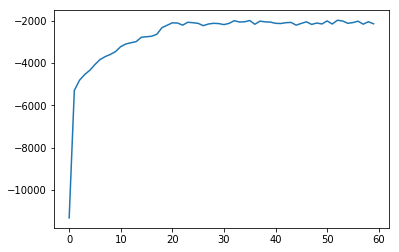

In [77]:
plt.plot(free_energies)
plt.show()